## Hausarbeit - Aufgabe 2
In dieser Aufgabe werden 10 Pferdebilder mittels des Netzwerks CycleGAN in Zebrabilder umgewandelt.

### 1.Schritt: Erstellung eines ResNet-Generators zur Transformation der Pferdebilder in Zebrabilder

In [1]:

import torch
import torch.nn as nn

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)




### 2.Schritt: Einladen der nötigen Bibliotheken und Netzwerke

In [2]:
from PIL import Image
from torchvision import transforms
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt

netG = ResNetGenerator()
model_path = 'horse2zebra_0.4.0.pth'
model_data = torch.load(model_path)
netG.load_state_dict(model_data)
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

### 3.Schritt: Einladen der Pferdebilder und Durchführung des Preprocessings

In [3]:
preprocess = transforms.Compose([transforms.Resize(256),transforms.ToTensor()])
# Pfad der Pferdebilder
picture_directory = 'horse_pictures'

# Leere Listen für die Bilder (Original und Prepocessed)
pictures = []
preprocessed_pictures = []

for file in os.listdir(picture_directory):
    # Öffnen der Bilddatei
    picture = Image.open(os.path.join(picture_directory, file))
    # Anhängen der Bilddatei an die Liste "Pictures"
    pictures.append(picture)

    # Durchführung des Preprocessings
    preprocessed_picture = preprocess(picture)
    batch_t = torch.unsqueeze(preprocessed_picture, 0)
    
    # Anhängen der bearbeiteten Bilder an die Liste "Preprocessed_pictures"
    batch_out = netG(batch_t)
    out_t = (batch_out.data.squeeze() + 1.0) / 2.0
    out_img = transforms.ToPILImage()(out_t)
    preprocessed_pictures.append(out_img)

### 4.Schritt: Darstellung der Ergebnisse im Subplot

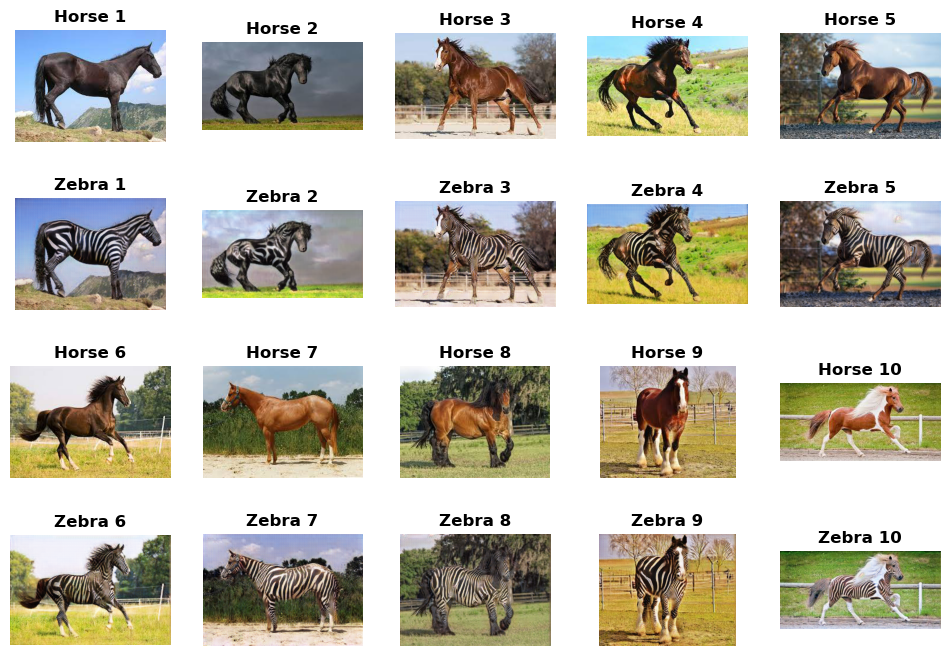

In [4]:
# Definition der Subplots
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(12, 8))

# Iteration über alle Bilder und Positionierung im Plot
i = 0

### ORIGINAL - HORSE ###
while i < len(pictures):
    row = 2 * (i // 5)  # Integer Division - Floor
    col = i % 5   # Modulus Operator - Rest
    axs[row, col].imshow(pictures[i])
    axs[row, col].set_axis_off()
    axs[row, col].set_title(f"Horse {i+1}", weight='bold')
    i += 1

j = 0
### TRANSFORM - ZEBRA ###
while j < len(preprocessed_pictures):
    row = 2 * (j // 5) + 1  # Integer Division - Floor
    col = j % 5   # Modulus Operator - Rest
    axs[row, col].imshow(preprocessed_pictures[j])
    axs[row, col].set_axis_off()
    axs[row, col].set_title(f"Zebra {j+1}", weight='bold')
    j += 1

# Anpassung der Abstände zwischen den Subplots
plt.subplots_adjust(wspace=0.2, hspace=0.5)
# Anzeigen des Subplots
plt.show()